In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import math as mt

In [2]:
def rk4(f,x,t,dt,p):
    """
    Calcula un paso de integración del método de Runge Kutta orden 4.
    
    Argumentos de entrada:
    
        f : R^n -> R^n
        x = x(t) : R^n
        t = tiempo : R
        dt = paso de tiempo : R
        p = parametros : R^q        
        
    Retorna aproximacion numérica de
    
        x(t+dt) : R^n

    # Ejemplos:
    """    
    k1 = f(x,t,p)
    k2 = f(x+0.5*dt*k1,t+0.5*dt,p)
    k3 = f(x+0.5*dt*k2,t+0.5*dt,p)
    k4 = f(x+dt*k3,t+dt,p)
    return x+dt*(k1+2.0*k2+2.0*k3+k4)/6.0

In [3]:
def integrador_ode(m,f,x0,a,b,k,p):
    """
    Integra numéricamente la ODE
    
        dx/dt = f(x,t)
        
    sobre el intervalo t:[a,b] usando k pasos de integración y el método m, bajo condicion inicial x(a)=x0.
    No es necesario que a<b.
    
    Argumentos de entrada:
    
        m = metodo de integracion (ej. euler, rk2, etc.)
        f : R^n -> R^n
        x0 = condicion inicial : R
        a = tiempo inicial : R
        b = tiempo final : R
        k = num. pasos de integracion : N
        p = parametros : R^q        
    
    Retorna:
    
        t : R^{k+1} , t_j = a+j*dt para j=0,1,...,k
        x : R^{k+1,n} , x_ij = x_i(t_j) para i=0,1,...,n-1 y j=0,1,...,k
        
    donde a+k*dt = b.
    """  
    assert k>0
    n = len(x0)
    dt = (b-a)/k
    x = np.zeros((n,k+1))
    t = np.zeros(k+1)
    x[:,0] = x0
    t[0] = a
    for j in range(k):
        t[j+1] = t[j] + dt
        x[:,j+1] = m(f,x[:,j],t[j],dt,p)
    return t,x

## Redes Neuronales: Práctico 2
----------
### Modelo neuronal de Izhikevich
Consiste de dos ecuaciones de la forma 
$$
\dot{v}=0.04v^2+5v+140-u+I\\
\dot{u}=a(bv-u)
$$
con un reseteo auxiliar post disparo similar al del modelo Integrate-and-fire de la forma 
$$
v(t)\leftarrow\:c\\
u(t)\leftarrow\:u(t)+d
$$
cuando $v(t)>30\:mV$.

Aunque no estan explicitados en el paper, los valores iniciales para $v,u$ estan dados por el valor de reposo $V_r$ de $v$ para una corriente $I$ nula, y el parametro $c$, de forma que $V_0=V_r$ y $u_0=c.v_0$. Como el valor de $v_r$ es muy complicado de calcular analiticamente, lo que voy a hacer es dejar pasar suficiente tiempo para que cada neurona llegue al valor de reposo y luego aplicar el salto de corriente de $I=10$. 

Voy a probar primero el modelo sin el reseteo post disparo 

In [4]:
m=rk4
x0=[-65.0,0.2*(-65.0)]
ti=0.
tf=10.
#k=1000/0.1=10000
k=100
p=0

heaviside = lambda x: 0.5 if x == 0.1 else 0 if x < 0.1 else 1

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.2
    #I=0.
    I=10.0*heaviside(t)
    f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
    return np.array(f)

t_prueba,v_prueba = integrador_ode(m,f,x0,ti,tf,k,p)

/tmp/ipykernel_11447/4200774099.py:23: RuntimeWarning: overflow encountered in double_scalars
  f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
/tmp/ipykernel_11447/4200774099.py:23: RuntimeWarning: invalid value encountered in double_scalars
  f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))


Bueno claramente hay un problema de overflow, vamos a agregar corriente externa nula para ver si asi no da overflow.

In [5]:
m=rk4
x0=[-65.0,0.2*(-65.0)]
ti=0.
tf=10.
#k=1000/0.1=10000
k=100
p=0

heaviside = lambda x: 0.5 if x == 0.1 else 0 if x < 0.1 else 1

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.2
    I=0.
    #I=10.0*heaviside(t)
    f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
    return np.array(f)

t_prueba,v_prueba = integrador_ode(m,f,x0,ti,tf,k,p)

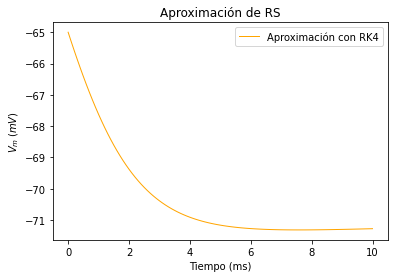

In [6]:
plt.title("Aproximación de RS")
plt.xlabel("Tiempo (ms)")
plt.ylabel(r'$V_m\:(mV)$')
plt.plot(t_prueba,v_prueba[0],label="Aproximación con RK4",color="orange",linestyle="-",linewidth=1)
plt.legend()
#plt.savefig("disparo_Ie_constante")
plt.show()

Vemos que ahora da bien, y sin el mecanismo de disparo y con corriente nula llega a un valor de reposo de alrededor de -71 mV. Ahora vamos a agregar el mecanismo de disparo. 

In [130]:
def integrador_ode_disparo(m,f,x0,a,b,k,p,c,d):
    assert k>0
    Vum=30.0
    #c=-65.0
    #d=8
    n = len(x0)
    dt = (b-a)/k
    x = np.zeros((n,k+1))
    t = np.zeros(k+1)
    x[:,0] = x0
    t[0] = a
    for j in range(k):
        t[j+1] = t[j] + dt
        x[:,j+1] = m(f,x[:,j],t[j],dt,p)
        if x[0,j+1] > Vum:
            x[0,j+1] = c
            x[1,j+1] = x[1,j+1]+d
    return t,x

In [131]:
m=rk4
x0=[-65.0,0.2*(-65.0)]
ti=0.
tf=500.
#k=1000/0.1=10000
k=5000
p=0
c=-65.0
d=8

heaviside = lambda x: 0.5 if x == 50 else 0 if x < 50 else 1

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.2
    I=10.0*heaviside(t)
    f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
    return np.array(f)

t_prueba,v_prueba = integrador_ode_disparo(m,f,x0,ti,tf,k,p,c,d)

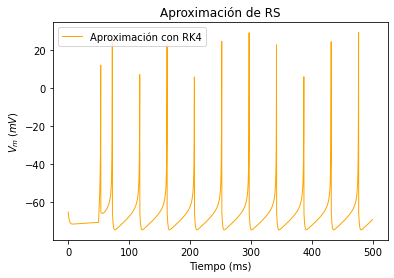

In [132]:
plt.title("Aproximación de RS")
plt.xlabel("Tiempo (ms)")
plt.ylabel(r'$V_m\:(mV)$')
plt.plot(t_prueba,v_prueba[0],label="Aproximación con RK4",color="orange",linestyle="-",linewidth=1)
plt.legend()
#plt.savefig("disparo_Ie_constante")
plt.show()

Esto fue una prueba pero salio bien, y los valores que use para los parametros son los correspondientes a los de las neuronas corticales excitatorias de tipo RS (regular spiking). Voy a hacer lo mismo para todas las demas.

----------
### Neuronas corticales excitatorias 
#### 1. RS (regular spiking)

a=0.02

b=0.2

c=-65 mV

d=8

In [344]:
m=rk4
a=0.02
b=0.2
c=-65.0
d=8
x0=[-70.0,-b*70.0]
ti=0.
tf=500.
#k=1000/0.01=10000
k=50000
p=0


heaviside = lambda x: 0.5 if x == 50 else 0 if x < 50 else 1

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.2
    I=10.0*heaviside(t)
    f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
    return np.array(f)

t_RS,v_RS = integrador_ode_disparo(m,f,x0,ti,tf,k,p,c,d)

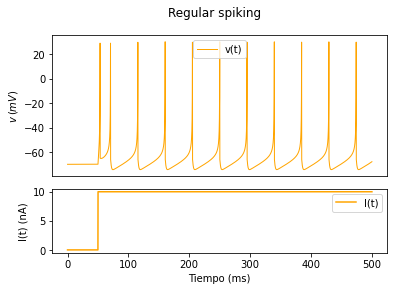

In [346]:
plt.subplots(3, 1, sharex=True)

plt.subplot(3,1,(1,2))
plt.xticks([])
plt.ylabel(r'$v\:(mV)$')
plt.plot(t_RS,v_RS[0],label="v(t)",color="orange",linestyle="-",linewidth=1)
plt.legend()

I=np.linspace(0,500,5000)
plt.subplot(3,1,3)
#ax2.xlabel("Tiempo (ms)")
plt.ylabel("I(t) (nA)")
plt.plot(I,10.0*np.vectorize(heaviside)(I),label="I(t)",color="orange",linestyle="-")
plt.legend()

plt.xlabel("Tiempo (ms)")
plt.suptitle("Regular spiking")
plt.savefig("RS.pdf")
plt.show()

#### 2. IB (intrinsically bursting)

a=0.02

b=0.2

c=-55 mV

d=4

In [361]:
m=rk4
a=0.02
b=0.2
c=-55.0
d=4
x0=[-70.0,-b*70.0]
ti=0.
tf=250.
#k=1000/0.1=10000
k=25000
p=0


heaviside = lambda x: 0.5 if x == 50 else 0 if x < 50 else 1

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.2
    I=10.0*heaviside(t)
    f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
    return np.array(f)

t_IB,v_IB = integrador_ode_disparo(m,f,x0,ti,tf,k,p,c,d)

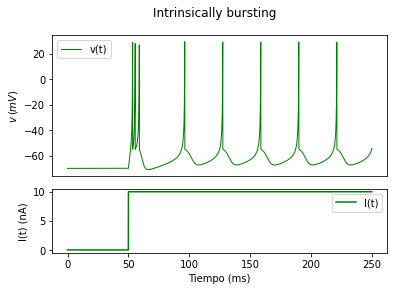

In [363]:
plt.subplots(3, 1, sharex=True)

plt.subplot(3,1,(1,2))
plt.xticks([])
plt.ylabel(r'$v\:(mV)$')
plt.plot(t_IB,v_IB[0],label="v(t)",color="green",linestyle="-",linewidth=1)
plt.legend()

I=np.linspace(0,250,2500)
plt.subplot(3,1,3)
#ax2.xlabel("Tiempo (ms)")
plt.ylabel("I(t) (nA)")
plt.plot(I,10.0*np.vectorize(heaviside)(I),label="I(t)",color="green",linestyle="-")
plt.legend()

plt.xlabel("Tiempo (ms)")
plt.suptitle("Intrinsically bursting")
plt.savefig("IB.pdf")
plt.show()

#### 3. CH (chattering)

a=0.02

b=0.2

c=-50 mV

d=2

In [373]:
m=rk4
a=0.02
b=0.2
c=-50.0
d=2
x0=[-70,-b*70]
ti=0.
tf=250.
#k=1000/0.1=10000
k=250000
p=0


heaviside = lambda x: 0.5 if x == 50 else 0 if x < 50 else 1

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.2
    I=10.0*heaviside(t)
    f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
    return np.array(f)

t_CH,v_CH = integrador_ode_disparo(m,f,x0,ti,tf,k,p,c,d)

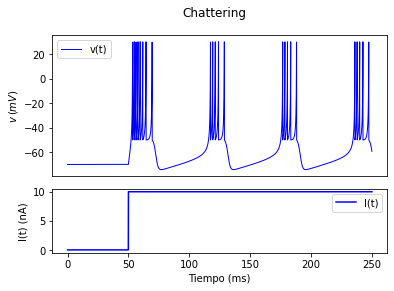

In [374]:
plt.subplots(3, 1, sharex=True)

plt.subplot(3,1,(1,2))
plt.xticks([])
plt.ylabel(r'$v\:(mV)$')
plt.plot(t_CH,v_CH[0],label="v(t)",color="blue",linestyle="-",linewidth=1)
plt.legend()

I=np.linspace(0,250,2500)
plt.subplot(3,1,3)
#ax2.xlabel("Tiempo (ms)")
plt.ylabel("I(t) (nA)")
plt.plot(I,10.0*np.vectorize(heaviside)(I),label="I(t)",color="blue",linestyle="-")
plt.legend()

plt.xlabel("Tiempo (ms)")
plt.suptitle("Chattering")
plt.savefig("CH.pdf")
plt.show()

----------
### Neuronas corticales inhibitorias 
#### 1. FS (fast spiking)

a=0.1

b=0.2

c=-65 mV

d=2

In [390]:
m=rk4
a=0.1
b=0.2
c=-65.0
d=2
x0=[-70.0,-b*70.0]
ti=0.
tf=500.
#k=1000/0.1=10000
k=100000
p=0


heaviside = lambda x: 0.5 if x == 50 else 0 if x < 50 else 1

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.2
    I=10.0*heaviside(t)
    f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
    return np.array(f)

t_FS,v_FS = integrador_ode_disparo(m,f,x0,ti,tf,k,p,c,d)

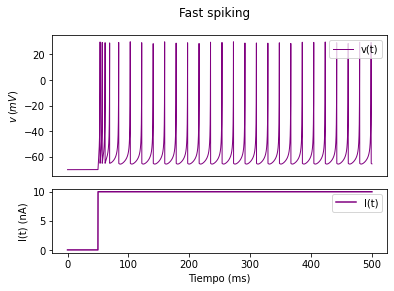

In [393]:
plt.subplots(3, 1, sharex=True)

plt.subplot(3,1,(1,2))
plt.xticks([])
plt.ylabel(r'$v\:(mV)$')
plt.plot(t_FS,v_FS[0],label="v(t)",color="purple",linestyle="-",linewidth=1)
plt.legend()

I=np.linspace(0,500,5000)
plt.subplot(3,1,3)
#ax2.xlabel("Tiempo (ms)")
plt.ylabel("I(t) (nA)")
plt.plot(I,10.0*np.vectorize(heaviside)(I),label="I(t)",color="purple",linestyle="-")
plt.legend()

plt.xlabel("Tiempo (ms)")
plt.suptitle("Fast spiking")
plt.savefig("FS.pdf")
plt.show()

#### 2. LTS (low-threshold spiking)

a=0.02

b=0.25

c=-65 mV

d=2

In [398]:
m=rk4
a=0.02
b=0.25
c=-65.0
d=2
x0=[-65.0,-b*65.0]
ti=0.
tf=250.
#k=1000/0.1=10000
k=50000
p=0


heaviside = lambda x: 0.5 if x == 70 else 0 if x < 70 else 1

def f(x,t,p): 
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.25
    I=10.0*heaviside(t)
    f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
    return np.array(f)

t_LTS,v_LTS = integrador_ode_disparo(m,f,x0,ti,tf,k,p,c,d)

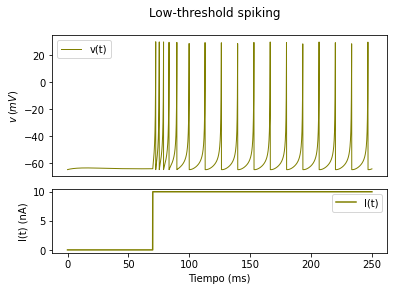

In [400]:
plt.subplots(3, 1, sharex=True)

plt.subplot(3,1,(1,2))
plt.xticks([])
plt.ylabel(r'$v\:(mV)$')
plt.plot(t_LTS,v_LTS[0],label="v(t)",color="olive",linestyle="-",linewidth=1)
plt.legend()

I=np.linspace(0,250,2500)
plt.subplot(3,1,3)
#ax2.xlabel("Tiempo (ms)")
plt.ylabel("I(t) (nA)")
plt.plot(I,10.0*np.vectorize(heaviside)(I),label="I(t)",color="olive",linestyle="-")
plt.legend()

plt.xlabel("Tiempo (ms)")
plt.suptitle("Low-threshold spiking")
plt.savefig("LTS.pdf")
plt.show()

----------
### Neuronas talamo-corticales
#### 1. TC (thalamo-cortical), primer regimen

a=0.02

b=0.2

c=-65 mV

d=0.05

In [224]:
m=rk4
a=0.02
b=0.25
c=-63.0
d=0.05
x0=[-63.0,-b*63.0]
ti=0.
tf=200.
#k=1000/0.1=10000
k=20000
p=0

def Itc1(t):
    if t>10:
        return 1.0
    else:
        return 0.0
#heaviside_TC1 = lambda x: 0 if x < 10 else 1

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.25
    #I=5*Itc1(t)
    f=(0.04*v**2+5.*v+140.-u+1.3*Itc1(t), a*(b*v-u))
    return np.array(f)

t_TC1,v_TC1 = integrador_ode_disparo(m,f,x0,ti,tf,k,p,c,d)

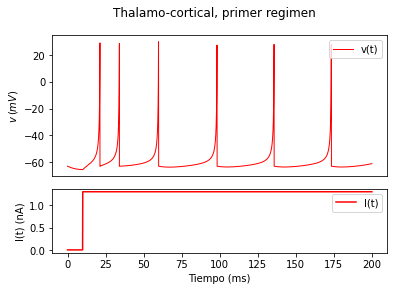

In [401]:
plt.subplots(3, 1, sharex=True)

plt.subplot(3,1,(1,2))
plt.xticks([])
plt.ylabel(r'$v\:(mV)$')
plt.plot(t_TC1,v_TC1[0],label="v(t)",color="red",linestyle="-",linewidth=1)
plt.legend()

I=np.linspace(0,200,2000)
plt.subplot(3,1,3)
#ax2.xlabel("Tiempo (ms)")
plt.ylabel("I(t) (nA)")
plt.plot(I,1.3*np.vectorize(Itc1)(I),label="I(t)",color="red",linestyle="-")
plt.legend()

plt.xlabel("Tiempo (ms)")
plt.suptitle("Thalamo-cortical, primer regimen")
plt.savefig("TC1.pdf")
plt.show()

#### 2. TC (thalamo-cortical), segundo regimen

a=0.02

b=0.2

c=-65 mV

d=0.05

con un salto de corriente negativo

In [238]:
m=rk4
a=0.02
b=0.2577
c=-63.0
d=0.75
x0=[-87.0,-b*87.0]
ti=0.
tf=150.
#k=1000/0.1=10000
k=15000
p=0


def Itc2(t):
    if t>10:
        return 0.0
    else:
        return -1.0

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.02
    b=0.2577
    I=30.19*Itc2(t)
    f=(0.04*v**2+5.*v+140.-u+I, a*(b*v-u))
    return np.array(f)

t_TC2,v_TC2 = integrador_ode_disparo(m,f,x0,ti,tf,k,p,c,d)

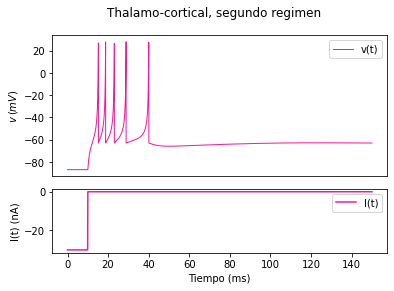

In [402]:
plt.subplots(3, 1, sharex=True)

plt.subplot(3,1,(1,2))
plt.xticks([])
plt.ylabel(r'$v\:(mV)$')
plt.plot(t_TC2,v_TC2[0],label="v(t)",color="deeppink",linestyle="-",linewidth=1)
plt.legend()

I=np.linspace(0,150,1500)
plt.subplot(3,1,3)
#ax2.xlabel("Tiempo (ms)")
plt.ylabel("I(t) (nA)")
plt.plot(I,30.19*np.vectorize(Itc2)(I),label="I(t)",color="deeppink",linestyle="-")
plt.legend()

plt.xlabel("Tiempo (ms)")
plt.suptitle("Thalamo-cortical, segundo regimen")
plt.savefig("TC2.pdf")
plt.show()

----------
### Resonador


- **RZ (resonator)**

a=0.1

b=0.26

c=-65 mV

d=2

In [415]:
m=rk4
#a=0.1
b=0.2577
c=-65.0
d=2
x0=[c,b*c]
ti=0.
tf=140.
#k=1000/0.1=10000
k=14000
p=0


def Irz(t):
    if t<10:
        return 0
    else:
        if ((t>20) and (t<60)):
            return 0.015
        else:
            if ((t>60) and (t<62)):
                return 2.6
            else:
                if ((94 < t) and (t<96)):
                    return 2.6
                else:
                    if ((125<t) and t<127):
                        return 2.6
                    else:
                        return 0.015
                        
def Irz2(t):
    if t<50:
        return 0
    else:
        return 1.0
    

def f(x,t,p):
    
    if isinstance(x,np.ndarray):
        v=x[0]
        u=x[1]
    else:
        raise ValueError("X must be a vector")
    
    a=0.1
    b=0.2577
    #I=10.0*Irz(t)
    f=(0.04*v**2+5.*v+140.-u+Irz(t), a*(b*v-u))
    return np.array(f)

t_RZ,v_RZ = integrador_ode_disparo(m,f,x0,ti,tf,k,p,c,d)

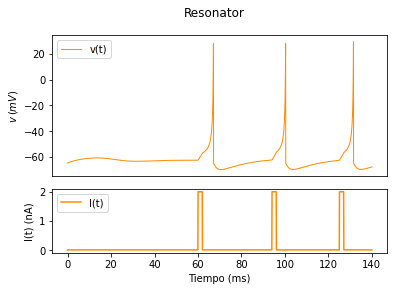

In [417]:
plt.subplots(3, 1, sharex=True)

plt.subplot(3,1,(1,2))
plt.xticks([])
plt.ylabel(r'$v\:(mV)$')
plt.plot(t_RZ,v_RZ[0],label="v(t)",color="darkorange",linestyle="-",linewidth=1)
plt.legend()

I=np.linspace(0,140,1400)
plt.subplot(3,1,3)
#ax2.xlabel("Tiempo (ms)")
plt.ylabel("I(t) (nA)")
plt.plot(I,np.vectorize(Irz)(I),label="I(t)",color="darkorange",linestyle="-")
plt.legend()

plt.xlabel("Tiempo (ms)")
plt.suptitle("Resonator")
plt.savefig("RZ.pdf")
plt.show()